# A comet-like transit from Kepler KIC 12557548 with TLS
We will use TLS to recover the exoplanet KIC 12557548b from the Kepler mission,
announced in Rappaport et al. (2012).
We will download the curves thanks to the `lightkurve` package. Then, we will
execute TLS with the known stellar parameters from TESS ExoFOP. We will compare
the TLS execution for the default transit template and the exocomets one.

In [1]:
import matplotlib.pyplot as plt; plt.rcParams["figure.dpi"] = 150
import lightkurve as lk
import transitleastsquares as tls
import numpy

lcf = lk.search_lightcurvefile("KIC 12557548", mission="Kepler", cadence="short", quarter=14).download_all()
power_args = {'transit_template': 'default', 'period_min': 0.5, 'period_max': 1, 'n_transits_min': 2, 'u': (0.701, 0.0462), 'R_star': 0.66, 'R_star_min': 0.606, 'R_star_max': 0.71400005, 'M_star': 0.666, 'M_star_min': 0.611, 'M_star_max': 0.73300004}
pdcsap_flux = lcf.PDCSAP_FLUX.stitch().remove_nans()
model = tls.transitleastsquares(pdcsap_flux.time, pdcsap_flux.flux)
results = model.power(**power_args)

/home/martin/git_repositories/transitleastsquares/transitleastsquares/template_generator/transit_template_generator.py:190: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lc_arr = numpy.array(lc_arr)
100%|██████████| 3979/3979 periods | 05:10<00:00


Transit Least Squares TLS 1.0.25 (04 June 2020)
Creating model cache for 20 durations
Searching 128922 data points, 3979 periods from 0.5 to 1.0 days
Using all 8 CPU threads


Let's see the parameters and the periodiogram for the default template results:

Duration: 0.04309081194318918
SNR: 86.63611018080842
SDE: 25.32236000291283
Chi2 reduced: 0.9433267623750554


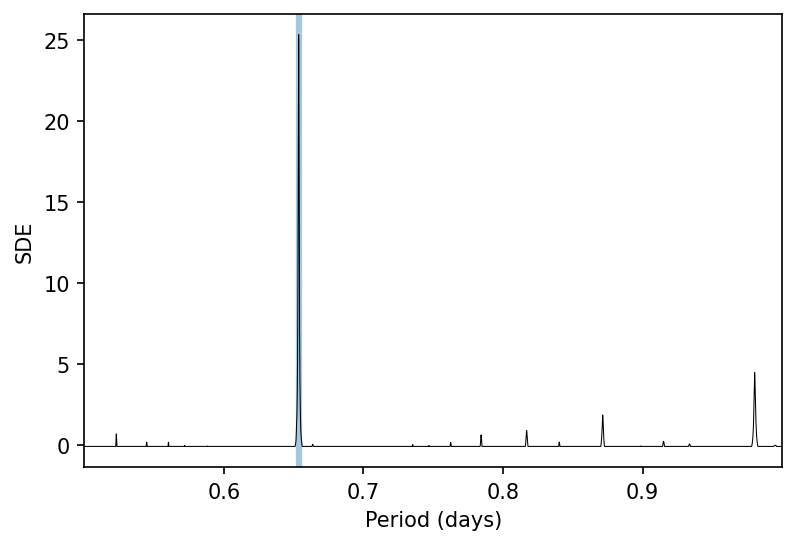

In [13]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(min(results.periods), max(results.periods))

print("Duration: " + str(results.duration))
print("SNR: " + str(results.snr))
print("SDE: " + str(results.SDE))
print("Chi2 reduced: " + str(min(results.chi2red)))

That's a strong signal. Let's look at the phase fold:

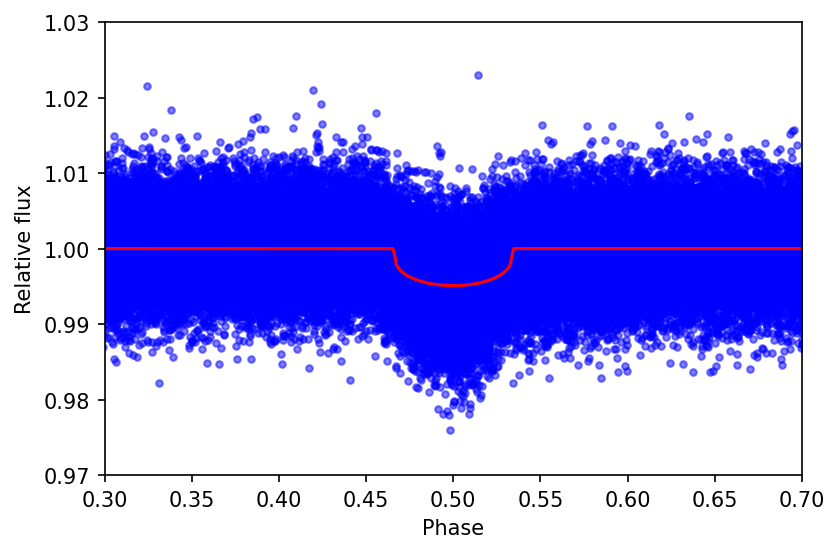

In [8]:
plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.3, 0.7)
plt.ylim(0.97, 1.03)
plt.xlabel('Phase')
plt.ylabel('Relative flux');


We can see that the fit is good enough. However, even having good fit parameters,
we can visually see that the transit is somehow weird, showing a slower flux
recovery. That'd seem more like a cometary transit. Let's try TLS with such a
template:

In [9]:
lcf = lk.search_lightcurvefile("KIC 12557548", mission="Kepler", cadence="short", quarter=14).download_all()
power_args_comet = {'transit_template': 'tailed', 'period_min': 0.5, 'period_max': 1, 'n_transits_min': 2, 'u': (0.701, 0.0462), 'R_star': 0.66, 'R_star_min': 0.606, 'R_star_max': 0.71400005, 'M_star': 0.666, 'M_star_min': 0.611, 'M_star_max': 0.73300004}
pdcsap_flux_comet = lcf.PDCSAP_FLUX.stitch().remove_nans()
model_comet = tls.transitleastsquares(pdcsap_flux_comet.time, pdcsap_flux_comet.flux)
results_comet = model_comet.power(**power_args_comet)

/home/martin/git_repositories/transitleastsquares/transitleastsquares/template_generator/transit_template_generator.py:190: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lc_arr = numpy.array(lc_arr)
100%|██████████| 3979/3979 periods | 44:20<00:00  


Transit Least Squares TLS 1.0.25 (04 June 2020)
Creating model cache for 42 durations
Searching 128922 data points, 3979 periods from 0.5 to 1.0 days
Using all 8 CPU threads


Let's inspect the parameters and the periodiogram for the comet template results:

Duration: 0.1352374269784532
SNR: 51.397963449525065
SDE: 24.8068605167482
Chi2 reduced: 0.9425413158610472


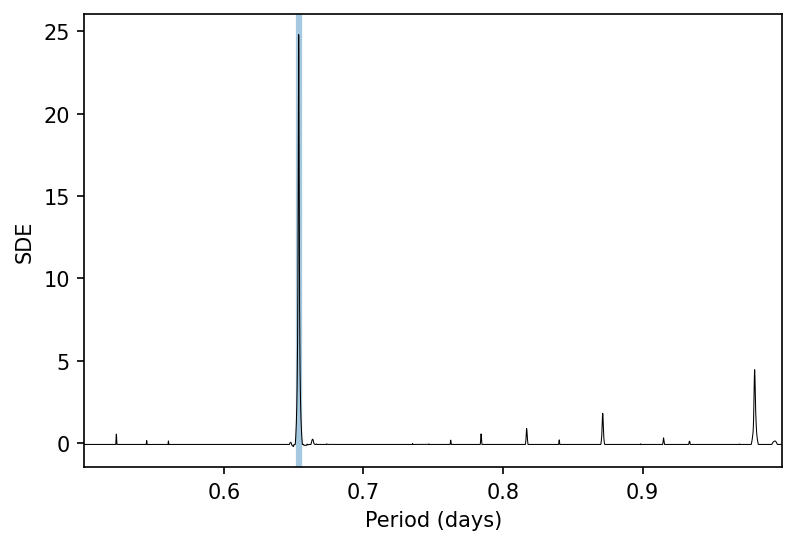

In [14]:
plt.figure()
ax = plt.gca()
ax.axvline(results_comet.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results_comet.periods), numpy.max(results_comet.periods))
for n in range(2, 10):
    ax.axvline(n*results_comet.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results_comet.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results_comet.periods, results_comet.power, color='black', lw=0.5)
plt.xlim(min(results_comet.periods), max(results_comet.periods))

print("Duration: " + str(results_comet.duration))
print("SNR: " + str(results_comet.snr))
print("SDE: " + str(results_comet.SDE))
print("Chi2 reduced: " + str(min(results_comet.chi2red)))

That's a strong signal again, at the same period. However, the duration seems to be
four times higher. Let's look at the phase fold:

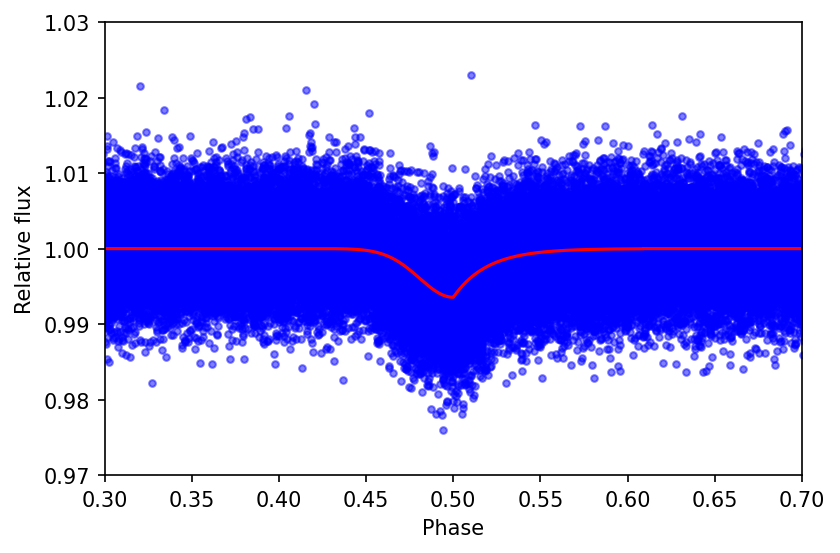

In [11]:
plt.figure()
plt.plot(results_comet.model_folded_phase, results_comet.model_folded_model, color='red')
plt.scatter(results_comet.folded_phase, results_comet.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.3, 0.7)
plt.ylim(0.97, 1.03)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

It seems that the cometary shape makes sense here. We conclude that TLS was able
to spot the exoplanet with both methods.

Mathematically, we can see that the SNR and SDE were slightly better for the TLS default
template. However, we can note that the residuals are better for the comet template.
This is probably related to the comet-like template not being parameterizable (the
ingress and egress shapes). If the ingress and egress parameters were fine-tuned, it'd
probably return even better results. However, you could use your own implementation of the
TransitTemplateGenerator class provided by TLS. Have a look at the next tutorial to
learn how to do it with a stellar flares example!